# AI model for training (shark fin) artifacts on GOES-R

[How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images](https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5)

[TRAINING A CLASSIFIER](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

[VISUALIZING MODELS, DATA, AND TRAINING WITH TENSORBOARD–Area Under Curve](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html?highlight=area%20under%20curve)


[PRECISION-RECALL Curves](https://www.scikit-yb.org/en/latest/api/classifier/prcurve.html)

In [1]:
#%load_ext tensorboard
%load_ext tensorboard
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os.path as op
import os
from subprocess import Popen
import tensorboard
import datetime
import sys
import time

# imports
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [66]:
nr.seed = 42
myTestData = []
myTrainData = []

In [67]:
data_dir = '/scratch/radomako/mydataset4/'
batch_size = 4
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
#     train_transforms = transforms.Compose([transforms.Resize(2712),
#                                        transforms.ToTensor(),
#                                        ])
#     test_transforms = transforms.Compose([transforms.Resize(2712),
#                                       transforms.ToTensor(),
#                                       ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=batch_size)
    
    myTestData.append(test_data)
    myTrainData.append(train_data)
    
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)

print(trainloader.dataset.classes)

['fillin', 'sharkfin']


In [68]:
testImages = myTestData[0].imgs
trainImages = myTrainData[0].imgs
print(len(trainImages))
print(len(testImages))

2758
2758


In [69]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
PATH = 'aerialmodel.pth'
model = torch.load(PATH)

# model = models.resnet50(pretrained=False)
# torch.save(model, 'aerialmodel.pth')


In [70]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
epochs = 1 #one epoch is a pass through all batches once "1:13" ratio, more epoch updates modes
#Aim for 1000 epochs (yes * batches)
#until stays flat for long time

steps = 0
running_loss = 0
print_every = 1#10 #batches #This is validation
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        print(steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print('REACHED RUNNING LOSS')
        if steps % print_every == 0:
            print('I am working')
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
#torch.save(model, 'aerialmodel.pth')

1
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 2.944.. Test loss: 0.833.. Test accuracy: 0.943
2
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 0.339.. Test accuracy: 0.944
3
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 0.566.. Test accuracy: 0.944
4
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 0.899.. Test accuracy: 0.944
5
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 1.271.. Test accuracy: 0.944
6
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 1.633.. Test accuracy: 0.944
7
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 2.043.. Test accuracy: 0.944
8
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 35.752.. Test loss: 2.033.. Test accuracy: 0.944
9
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 2.033.. Test accuracy: 0.943
10
REACHED RUNNING LOSS
I a

Epoch 1/1.. Train loss: 0.100.. Test loss: 0.624.. Test accuracy: 0.944
77
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 0.655.. Test accuracy: 0.944
78
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 0.730.. Test accuracy: 0.944
79
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.015.. Test loss: 0.761.. Test accuracy: 0.944
80
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 0.810.. Test accuracy: 0.944
81
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 0.880.. Test accuracy: 0.944
82
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.055.. Test loss: 0.949.. Test accuracy: 0.943
83
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 1.013.. Test accuracy: 0.944
84
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 5.362.. Test loss: 0.924.. Test accuracy: 0.944
85
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train l

REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.035.. Test loss: 0.255.. Test accuracy: 0.944
152
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.767.. Test loss: 0.251.. Test accuracy: 0.944
153
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.177.. Test loss: 0.254.. Test accuracy: 0.944
154
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.064.. Test loss: 0.255.. Test accuracy: 0.944
155
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.695.. Test loss: 0.276.. Test accuracy: 0.944
156
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.262.. Test loss: 0.288.. Test accuracy: 0.944
157
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.425.. Test loss: 0.272.. Test accuracy: 0.944
158
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.271.. Test loss: 0.252.. Test accuracy: 0.944
159
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.220.. Test loss: 0.239.. Test accuracy: 0.944
160
REACHED RU

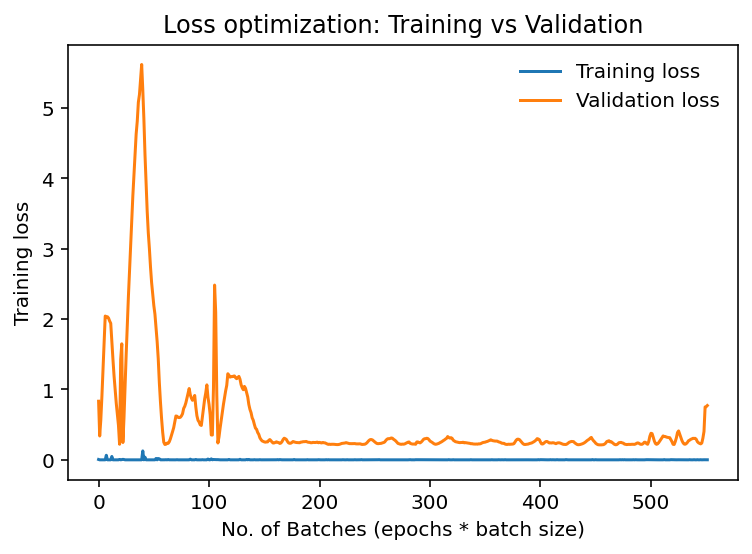

In [79]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss optimization: Training vs Validation')
plt.xlabel('No. of Batches (epochs * batch size)')
plt.ylabel('Training loss')
plt.legend(frameon=False)
plt.show()

#### Took 1 hour to train. Model (5424x5424 size) has 100 sharkfins and 889 fillins. Together that is 989 samples with a 1:9 ratio of sharkfins to fillins. The train to test split is 80% to 20%. Average test accuracy was over 90%

#### Dataset (224x224) has 166 sharkfins and 1320 fillins. Together that is 1486 samples with a ~1:8 ratio of sharkfins to fillins.

#### Average test accuracy is under 90% 



In [80]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
# trainset = torchvision.datasets.FashionMNIST('./data',
#     download=True,
#     train=True,
#     transform=transform)
# testset = torchvision.datasets.FashionMNIST('./data',
#     download=True,
#     train=False,
#     transform=transform)

# dataloaders
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                         shuffle=True, num_workers=2)


# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                         shuffle=False, num_workers=2)
trainset = trainloader
testset = testloader

# constant for classes
# classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
classes = trainloader.dataset.classes

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys", vmin=180,vmax=300)
        plt.grid(None) 
        plt.axis('off')
        
    else:
        #plt.imshow(np.transpose(npimg, (1, 2, 0)), vmin=180,vmax=300)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.grid(None) 
        plt.axis('off')

## Setting up convolution

[ValueError: Expected input batch_size (324) to match target batch_size (4)](https://discuss.pytorch.org/t/runtimeerror-given-groups-1-weight-of-size-64-3-7-7-expected-input-3-1-224-224-to-have-3-channels-but-got-1-channels-instead/30153)

In [81]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(32, 64, 5)
#         self.fc1 = nn.Linear(64*9*9, 1024)
#         self.fc2 = nn.Linear(1024, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(x.size(0), -1)
#         #x = x.view(-1, 64)
#         #x = F.relu(self.fc1(x))
#         #x = F.relu(self.fc2(x))
#         #x = self.fc2(x)
        return x


net = Net()

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [83]:
writer = SummaryWriter(f'logs/log{time.time()}')

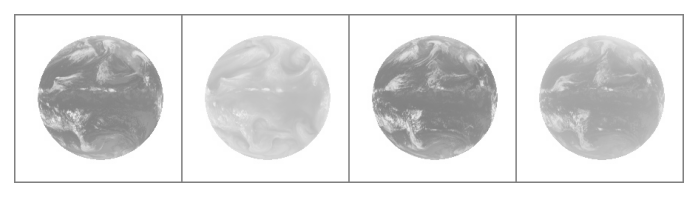

In [84]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)#, one_channel=True)

# write to tensorboard
# writer.add_image('four_fashion_mnist_images', img_grid)
try:
    writer.flush()
except:
    pass
writer.add_image(f'log/GOES_images{time.time()}', img_grid)

In [85]:
writer.add_graph(net, images)
writer.close()

mat1 and mat2 shapes cannot be multiplied (4x44944 and 400x120)
Error occurs, No graph saved


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x44944 and 400x120)

In [86]:
# def select_n_random(data, labels, n=100):
#     '''
#     Selects n random datapoints and their corresponding labels from a dataset
#     '''
#     assert len(data) == len(labels)

#     perm = torch.randperm(len(data))
#     return data[perm][:n], labels[perm][:n]


# # select random images and their target indices
# images, labels = select_n_random(trainset.data, trainset.targets)

# # get the class labels for each image
# class_labels = [classes[lab] for lab in labels]

# # log embeddings
# features = images.view(-1, 28 * 28)
# writer.add_embedding(features,
#                     metadata=class_labels,
#                     label_img=images.unsqueeze(1))
# writer.close()

In [87]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
#     for i in np.arange(4):
#         print(f'{i} index of predictions with length {len(preds)}: {preds[i]}')
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [88]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times
    
    if len(list(enumerate(trainloader, 0))) < 10:
            print('Batch size too small (<10) for PR-curve')
            
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:    # every 1000 mini-batches...
#         if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
        
print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x44944 and 400x120)

In [ ]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)